# Zero déchets sauvages : Hotspots visualization

## Setup and Preliminary Data Loading

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import folium
from shapely.geometry import Point
from folium import plugins
from folium.plugins import MarkerCluster
from branca.colormap import LinearColormap

In [2]:
# Load the data (cleaned and enriched by Floriane) 
data_zds = pd.read_csv('data_zds_enriched.csv', low_memory=False)
data_zds.head(2)

ID_RELEVE LIEU_PAYS                 LIEU_REGION  LIEU_DEPT LIEU_VILLE  \
0         12    France  Provence-Alpes-Côte d'Azur       13.0  Marseille   
1         14    France  Provence-Alpes-Côte d'Azur       13.0  Marseille   

   LIEU_CODE_POSTAL                         LIEU_COORD_GPS  LIEU_COORD_GPS_X  \
0           13008.0  ["5.3416741728752","43.213786286934"]          5.341674   
1           13008.0  ["5.3429503182801","43.213941067785"]          5.342950   

   LIEU_COORD_GPS_Y              NOM_ZONE  ...  INSEE_COM  DEP REG       EPCI  \
0         43.213786  Anse de la Maronaise  ...      13055   13  93  200054807   
1         43.213941  Anse de la Maronaise  ...      13055   13  93  200054807   

  NATURE_EPCI BV2022                             LIBEPCI       DEPARTEMENT  \
0          ME  13055  Métropole d'Aix-Marseille-Provence  Bouches-du-Rhône   
1          ME  13055  Métropole d'Aix-Marseille-Provence  Bouches-du-Rhône   

                       REGION BASSIN_DE_VIE  
0  Provence-Alpes-Côte d'Azur     Marseille  
1  Provence-Alpes-Côte d'Azur     Marseille  

[2 rows x 1302 columns]

In [3]:
data_zds.shape

(2796, 1302)

## Clean Data for Hotspot Visualization

**We have observed that there are 62 rows containing zero values in the volume_total column. These rows will be excluded from our calculations.**


In [4]:
# Count VOLUME_TOTAL = 0
num_rows_with_zero_volume = (data_zds['VOLUME_TOTAL'] == 0).sum()
print(f"Number of rows with VOLUME_TOTAL equal to 0: {num_rows_with_zero_volume}")

Number of rows with VOLUME_TOTAL equal to 0: 62


In [5]:
# Exclude rows where the volume_total equals 0 from dataset
data_zds_filtred = data_zds[data_zds['VOLUME_TOTAL'] != 0]

In [6]:
data_zds_filtred.shape

(2734, 1302)

In [7]:
# Calculate the maximum and mininum value in the 'VOLUME_TOTAL' column of the filtered dataset
max_volume = data_zds_filtred['VOLUME_TOTAL'].max()
min_volume = data_zds_filtred['VOLUME_TOTAL'].min()
print(f"The maximum value in VOLUME_TOTAL is: {max_volume}")
print(f"The minimum value in VOLUME_TOTAL is: {min_volume}")

The maximum value in VOLUME_TOTAL is: 387000.0
The minimum value in VOLUME_TOTAL is: 0.08


In [8]:
# Plot distribution of VOLUME_TOTAL
plt.figure(figsize=(10, 6))
sns.histplot(data_zds['VOLUME_TOTAL'], bins=50, color='skyblue', kde=False)
plt.title('Distribution of VOLUME_TOTAL')
plt.xlabel('VOLUME_TOTAL')
plt.ylabel('Count')
plt.show()

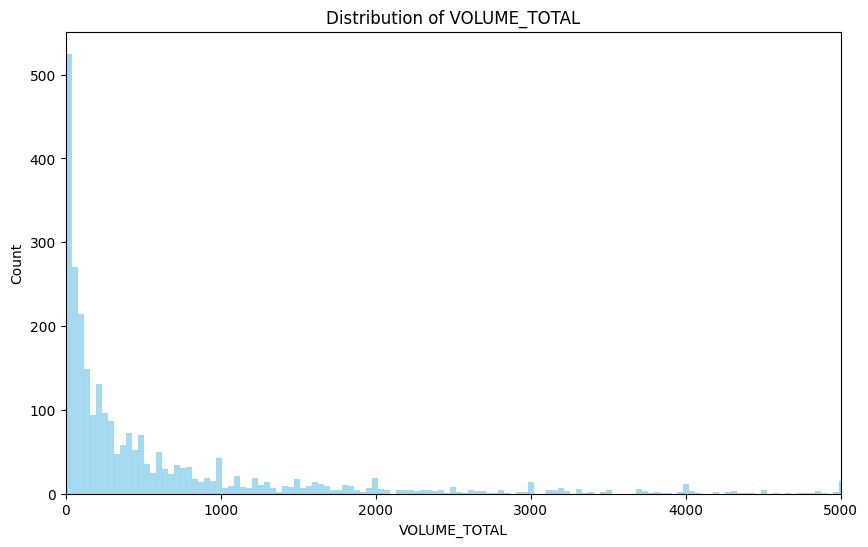

In [9]:
# Plot distribution of VOLUME_TOTAL within a limit of 5000
plt.figure(figsize=(10, 6))
sns.histplot(data_zds['VOLUME_TOTAL'], bins=10000, color='skyblue', kde=False)
plt.title('Distribution of VOLUME_TOTAL')
plt.xlabel('VOLUME_TOTAL')
plt.ylabel('Count')
plt.xlim(0, 5000)  # Set the x-axis limit to show values up to 50000
plt.show()

In [10]:
# Plot distribution of VOLUME_TOTAL focusing on the 0 to 1000 range
plt.figure(figsize=(10, 6))
# Adjust the number of bins to increase detail in the 0-1000 range
sns.histplot(data_zds[data_zds['VOLUME_TOTAL'] <= 1000]['VOLUME_TOTAL'], bins=50, color='skyblue', kde=False)
plt.title('Distribution of VOLUME_TOTAL (0-1000)')
plt.xlabel('VOLUME_TOTAL')
plt.ylabel('Count')
plt.xlim(0, 1000)  # Focus the plot on values from 0 to 1000
plt.show()

**We constated the same problem with 'SURFACE' column**

In [11]:
num_rows_with_zero_surface = (data_zds_filtred['SURFACE'] == 0).sum()
print(f"Number of rows with SURFACE equal to 0: {num_rows_with_zero_surface}")

Number of rows with SURFACE equal to 0: 1


In [12]:
rows_with_zero_surface = data_zds_filtred[data_zds_filtred['SURFACE'] == 0]

# Display the index of these rows
print("Index of rows with SURFACE equal to 0:")
print(rows_with_zero_surface.index.tolist())

Index of rows with SURFACE equal to 0:
[2607]


In [13]:
data_zds_filtered = data_zds[data_zds['SURFACE'] != 0]

In [14]:
data_zds_filtered.shape

(2795, 1302)

**Additionally, we will also change the dtype of the 'DATE' column from 'object' to 'datetime'**

In [15]:
dtype_of_date = data_zds_filtred['DATE'].dtype
print(dtype_of_date)

object


In [16]:
# Convert the 'DATE' column to datetime data type with the correct format
data_zds_filtred['DATE'] = pd.to_datetime(data_zds_filtred['DATE'], format='mixed')
print(data_zds_filtred['DATE'].dtype)

datetime64[ns]


/tmp/ipykernel_216525/84188442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zds_filtred['DATE'] = pd.to_datetime(data_zds_filtred['DATE'], format='mixed')


##  Cartography of Zones of Preferential Accumulations

In [17]:
# Create a GeoDataFrame for waste points
gdf = gpd.GeoDataFrame(
    data_zds_filtred, 
    geometry=gpd.points_from_xy(data_zds_filtred.LIEU_COORD_GPS_X, data_zds_filtred.LIEU_COORD_GPS_Y),
    crs="EPSG:4326"
)

# Initialize a folium map, centered around the mean location of the waste points
# The center is determined by the mean of the latitude and longitude of the points
map_center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=map_center, zoom_start=5)  # Adjust zoom_start as needed for the best initial view

# Optionally, use MarkerCluster to manage markers if dealing with a large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each waste point as a marker on the folium map
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Zone: {row['NOM_ZONE']}, Date: {row['DATE']}, Volume: {row['VOLUME_TOTAL']}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(marker_cluster)

# Display the map
m

In [18]:
# Set path for FRANCE_REGIONS GeoJSON file containing French regions
FRANCE_REGIONS = './regions-avec-outre-mer.geojson'

def plot_waste_spots_interactive(region: str, 
                                 dot_size_factor = 0.001, 
                                 max_dot_size = 20, 
                                 enable_max_dot_size = True # If False, relative differences between dots are realistics
                                 ) -> None:
    """
    Plots the waste spots of a given region interactively using Folium.
    
    Parameters:
    - region: str, the name of the region to plot.
    - dot_size_factor: float, factor to scale the dot sizes by waste volume.
    """
    # Load France regions from a GeoJSON file
    regions = gpd.read_file(FRANCE_REGIONS)
    regions = regions.loc[regions["nom"] == region, :]
    
    # Filter for the specified region
    selected_region = regions[regions["nom"].str.lower() == region.lower()]
    if selected_region.empty:
        print(f"Region '{region}' not found.")
        return None
    
    # Get bounds of the selected region to focus the map
    bounds = selected_region.bounds.iloc[0]
    map_center = [(bounds['miny'] + bounds['maxy']) / 2, (bounds['minx'] + bounds['maxx']) / 2]
    
    # Initialize the Folium map centered on the selected region
    m = folium.Map(location = map_center, zoom_start = 8)
    
    # Filter waste_data for spots within the selected region
    waste_data_spots = data_zds_filtred.loc[data_zds_filtred["LIEU_REGION"].str.lower() == region.lower(), ["LIEU_COORD_GPS", "NOM_ZONE", "DATE", "VOLUME_TOTAL"]]
    
    # Create the volume density serie
    volume_density = data_zds_filtred["VOLUME_TOTAL"] / data_zds_filtred["SURFACE"]

    # Compute the mean of volume density (excluding 'nan' and 'inf' values)
    volume_density_mean = volume_density[~volume_density.isin([np.nan, np.inf])].mean()

    # Replace the 'nan' values in volume_density by the mean
    volume_density.replace(to_replace = [np.nan, np.inf], value = volume_density_mean, inplace = True)

    # Create a linear range of colors corresponding to the volume density of waste per spot
    linear = cm.LinearColormap(["green", "yellow", "red"], vmin = volume_density.min(), vmax = volume_density.max())

    # Add waste spots as markers on the map
    for i, row in waste_data_spots.iterrows():
        # Check if coordinates are in list format
        if isinstance(row["LIEU_COORD_GPS"], list):
            # Calculate the radius, applying the dot_size_factor and ensuring it does not exceed max_dot_size
            if enable_max_dot_size:
                # Relative differences between markers are easier to represent on a map
                radius = min(max(1, row["VOLUME_TOTAL"] * dot_size_factor), max_dot_size)
            
            else:
                # Relative differences between markers are realistic
                radius = row["VOLUME_TOTAL"] * dot_size_factor

            folium.CircleMarker(
                location = [row["LIEU_COORD_GPS"][1], row["LIEU_COORD_GPS"][0]],  # Folium uses [lat, lon]
                radius = radius,  # Apply the calculated radius
                color = linear(volume_density[i]), # Apply the color corresponding to the density value
                fill = True,
                fill_color = linear(volume_density[i]), # Apply the color corresponding to the density value
                popup = f"Zone: {row['NOM_ZONE']}<br>Date: {row['DATE']}<br>Volume: {row['VOLUME_TOTAL']}",
            ).add_to(m)

    
    # Optionally, add the region boundary to the map for context
    folium.GeoJson(
        selected_region,
        name = "Region Boundary",
        style_function = lambda feature: {
            'weight': 2,
            'fillOpacity': 0.1,
        }
    ).add_to(m)
    
    return m

In [19]:
#plot_waste_spots_interactive("Provence-Alpes-Côte d'Azur")

## Mapping of Adopted Spots on the Territory

In [20]:
# Create a GeoDataFrame for waste points
gdf = gpd.GeoDataFrame(
    data_zds, 
    geometry=gpd.points_from_xy(data_zds.LIEU_COORD_GPS_X, data_zds.LIEU_COORD_GPS_Y),
    crs="EPSG:4326"
)

# Initialize a folium map, centered around the mean location of the waste points
map_center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=map_center, zoom_start=5)  # Adjust zoom_start as needed for the best initial view

# Use MarkerCluster to manage markers if dealing with a large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each waste point as a marker on the folium map
for _, row in gdf.iterrows():
    # Define the marker color: green for adopted spots, red for others
    marker_color = 'darkgreen' if row['SPOT_A1S'] else 'red'
    # Define the icon: check-circle for adopted, info-sign for others
    icon_type = 'check-circle' if row['SPOT_A1S'] else 'info-sign'
    
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Zone: {row['NOM_ZONE']}<br>Date: {row['DATE']}<br>Volume: {row['VOLUME_TOTAL']}",
        icon=folium.Icon(color=marker_color, icon=icon_type, prefix='fa')
    ).add_to(marker_cluster)

# Display the map
m

## Waste Densities in Studied Zones

In [21]:
# Compute waste density 
data_zds_filtred['waste_density'] = (data_zds_filtred['VOLUME_TOTAL'] / data_zds_filtred['SURFACE'])

/tmp/ipykernel_216525/2098547176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zds_filtred['waste_density'] = (data_zds_filtred['VOLUME_TOTAL'] / data_zds_filtred['SURFACE'])


In [22]:
# Aggregating waste densities by commune
density_by_commune = data_zds_filtred.groupby('commune')['waste_density'].mean()

In [23]:
# Sort the densities for better visualization and select the top 20, then reverse the order
density_filtered_by_commune_sorted = density_by_commune.sort_values(ascending=False).copy()
density_filtered_by_commune_sorted

commune
Bordeaux                       inf
Villeveyrac              87.526823
Villeurbanne             10.671718
Dossenheim-sur-Zinsel     9.763753
Biguglia                  3.676966
                           ...    
Sainte-Marie-la-Mer       0.000018
Lupiac                    0.000016
Banyuls-sur-Mer           0.000005
Roscanvel                 0.000005
Laguépie                  0.000004
Name: waste_density, Length: 422, dtype: float64

**Issue with Bordeaux showing "inf" values. Needs correction.**

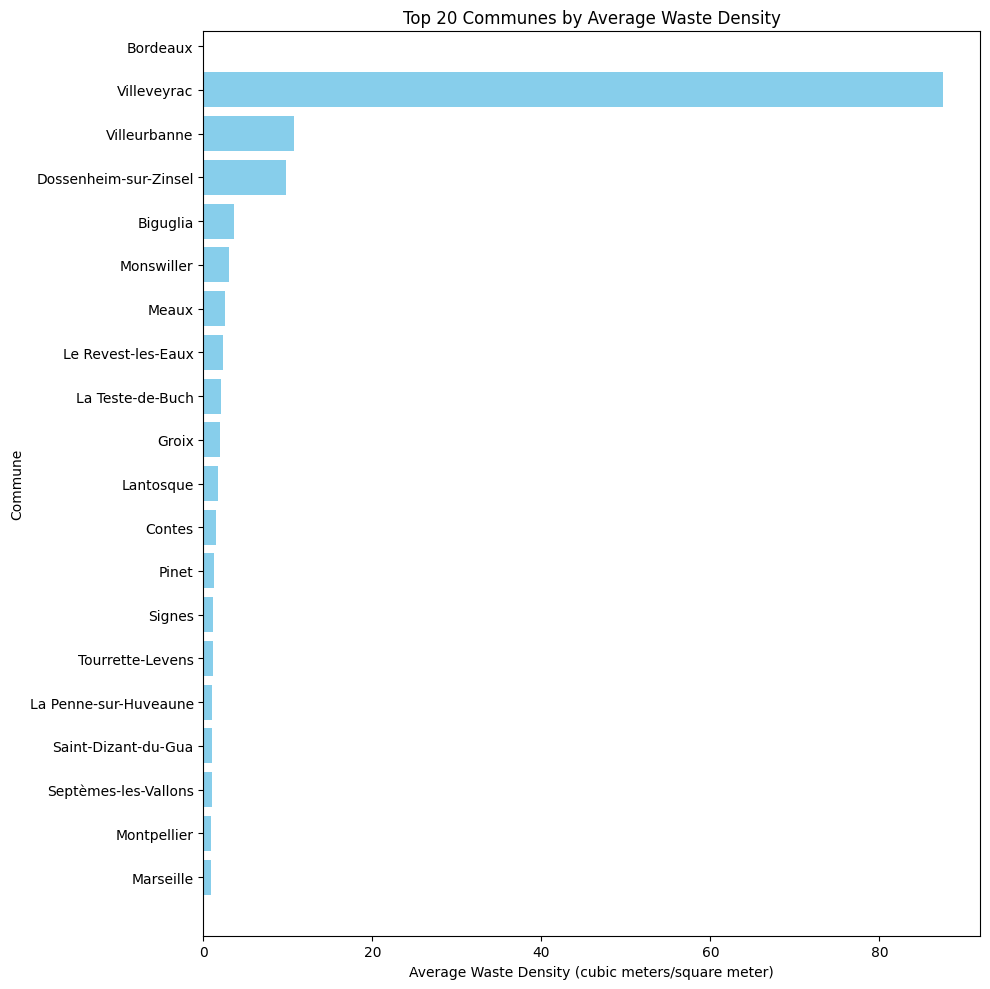

In [24]:
# Sort the densities for better visualization and select the top 20, then reverse the order
density_by_commune_sorted_top20 = density_by_commune.sort_values(ascending=False).head(20).iloc[::-1]

# Creating the horizontal bar chart with the highest density commune on top
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.barh(density_by_commune_sorted_top20.index, density_by_commune_sorted_top20.values, color='skyblue')
plt.ylabel('Commune')
plt.xlabel('Average Waste Density (cubic meters/square meter)')
plt.title('Top 20 Communes by Average Waste Density')
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()